In [24]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import regionmask
import rioxarray
from shapely.geometry import mapping, Point, Polygon
from xeofs.xarray import EOF

In [29]:
from geometric_features import FeatureCollection, read_feature_collection
from mpas_analysis.shared.analysis_task import AnalysisTask
from mpas_analysis.shared.constants import constants
from mpas_analysis.shared.plot import timeseries_analysis_plot, savefig, add_inset
from mpas_analysis.shared.io import open_mpas_dataset, write_netcdf
from mpas_analysis.shared.io.utility import build_config_full_path, make_directories, build_obs_path, decode_strings
from mpas_analysis.shared.html import write_image_xml
from mpas_analysis.ocean import time_series_antarctic_melt

In [41]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'
# Data file paths
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc' # Data containing regridded flux and SSH for 150 years
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson' # File contains all defined ice shelves

In [4]:
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/data/processed/E3SM_lowres_newrun_FluxSSH/'

In [52]:
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/data/raw/'

In [56]:
inDirExt = '/Users/smurugan9/research/aislens/aislens_emulation/data/external/'
oceanmesh = xr.open_dataset(inDirExt + 'ocean.ECwISC30to60E1r02.200408.nc')

In [88]:
oceanmesh.data_vars

Data variables:
    SSHGradientMeridional          (Time, nCells) float64 -8.287e-10 ... -2.6...
    SSHGradientZonal               (Time, nCells) float64 -5.195e-08 ... -3.8...
    accumulatedLandIceHeat         (Time, nCells) float64 0.0 0.0 ... 0.0 0.0
    accumulatedLandIceMass         (Time, nCells) float64 0.0 0.0 ... 0.0 0.0
    angleEdge                      (nEdges) float64 2.712 0.3729 ... 2.436 1.662
    areaCell                       (nCells) float64 1.149e+09 ... 7.943e+08
    areaTriangle                   (nVertices) float64 3.747e+08 ... 3.955e+08
    atmosphericPressure            (Time, nCells) float64 0.0 0.0 ... 0.0 0.0
    bottomDepth                    (nCells) float64 4.208e+03 ... 4.952e+03
    boundaryLayerDepth             (Time, nCells) float64 22.14 24.29 ... 46.45
    cellsOnCell                    (nCells, maxEdges) int32 225555 234093 ... 0
    cellsOnEdge                    (nEdges, TWO) int32 237830 237902 ... 213486
    cellsOnVertex                  (

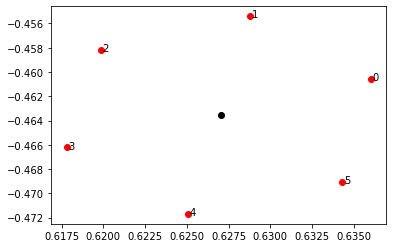

In [133]:
CELL_ID=1

f, ax = plt.subplots()
ax.plot(oceanmesh.lonCell.isel(nCells=CELL_ID),
        oceanmesh.latCell.isel(nCells=CELL_ID), 'ok')

for i in range(6):
    # Correct for zero-indexing.
    nCell = oceanmesh.cellsOnCell.isel(nCells=CELL_ID, maxEdges=i) - 1
    x = oceanmesh['lonCell'].isel(nCells=nCell)
    y = oceanmesh['latCell'].isel(nCells=nCell)
    ax.plot(x, y, 'or')
    ax.text(x+0.0001, y-0.0001, str(i))

In [135]:
verts = pd.DataFrame({'x': oceanmesh.lonCell, 'y': oceanmesh.latCell})
print(verts.head())

          x         y
0  4.817577  1.568825
1  0.627043 -0.463566
2  1.884537 -0.463344
3  2.512492  0.464314
4  3.141517 -0.461011


In [136]:
cell0 = oceanmesh.nCells # base cell
cell1 = oceanmesh.cellsOnCell.isel(maxEdges=1)-1
cell2 = oceanmesh.cellsOnCell.isel(maxEdges=2)-1

In [137]:
tris = np.stack([cell0, cell1, cell2]).T
# Remove any rows with -1 in them
tris = tris[~np.any(tris==-1, axis=1)]
tris = pd.DataFrame({'v0': tris[:, 0],
                     'v1': tris[:, 1],
                     'v2': tris[:, 2]})

In [70]:
areaCell = oceanmesh.areaCell
landIceFrac = oceanmesh.landIceFraction

In [111]:
data = xr.open_dataset(inDirName + 'mpaso.hist.am.timeSeriesStatsMonthly.0001-01-01.nc')
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

In [42]:
ds = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
rgflux = ds.timeMonthly_avg_landIceFreshwaterFlux
rgssh = ds.timeMonthly_avg_ssh

In [112]:
total_flux = constants.sec_per_year*(areaCell*flux).sum('nCells')
total_area = (landIceFrac*areaCell).sum(dim='nCells')
meltRates = ((1./constants.rho_fw)*(total_flux/total_area))

In [113]:
# convert from kg/yr to GT/yr
total_flux /= constants.kg_per_GT
totalMeltFluxes = total_flux

In [114]:
total_flux

<xarray.DataArray (Time: 1)>
array([1143.70347475])
Dimensions without coordinates: Time

In [125]:
1143.70347475/0.25156389

4546.37378500547

In [124]:
rgflts[0]

<xarray.DataArray 'timeMonthly_avg_landIceFreshwaterFlux' ()>
array(0.25156389)
Coordinates:
    time     datetime64[ns] 2001-01-31

In [126]:
rgflseries = rgflts*4546.37378500547

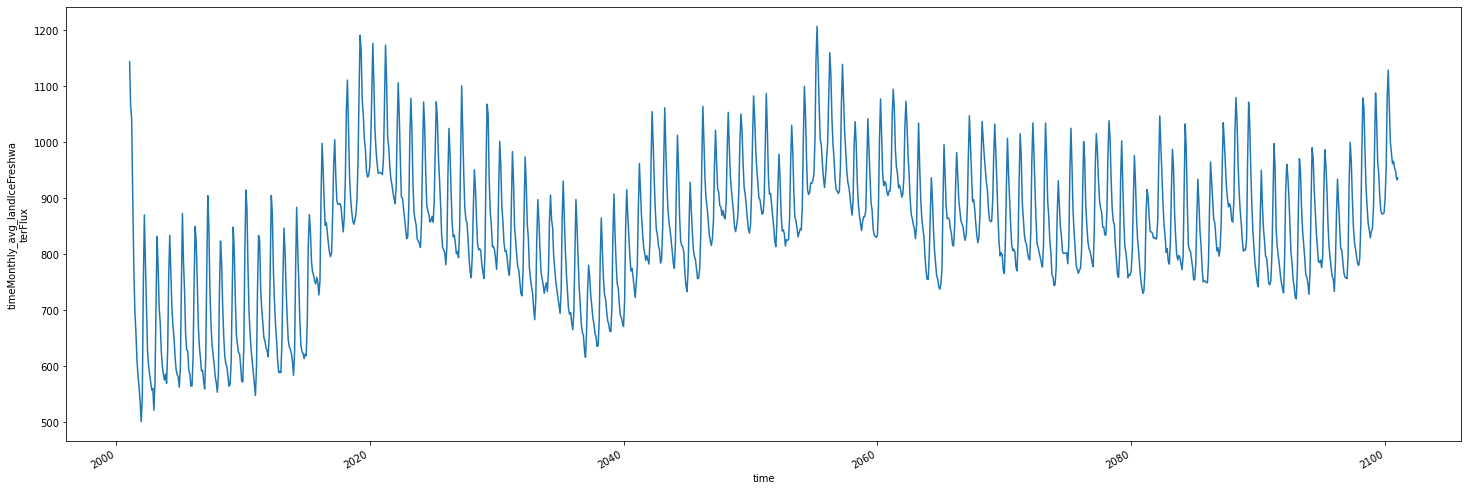

In [128]:
plt.figure(figsize=(25,8))
rgflseries[:1200].plot()

In [33]:
ds = time_series_antarctic_melt.open_mpas_dataset(inDirName + 'mpaso.hist.am.timeSeriesStatsMonthly.0001-02-01.nc')

TypeError: open_mpas_dataset() missing 1 required positional argument: 'calendar'

In [25]:
%%time
model = EOF(flux)
model.solve()

ValueError: One or more of ('time',) is not a valid dimension.

In [ ]:
icems.name.values[0]

In [ ]:
icems.name.values

In [ ]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh
lat = data.lat
lon = data.lon

# Presents a sample plot of the entire ice sheet with the flux data at any time stamp

# Time stamp
ts = 1200

"""

plt.figure(figsize=(15,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax.gridlines()
# ax.coastlines(resolution='10m',linewidth=0.75) 
# flux[ts].plot.contourf(ax=ax,levels=30)
flux[ts].plot()
# flux.mean('time').plot()
# icems.boundary.loc[[basin]].plot(ax=ax,color='blue',linewidth=0.25)
"""


# Read geoJSON region feature file as POLYGON (GeoDataFrame)
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'})
crs = ccrs.SouthPolarStereo()

#Masked data
data.rio.write_crs("epsg:3031",inplace=True)

## Following section tests the code for 1 ice shelf / catchment:
# Iceshelf chosen: 
#  34 : Amery
# 103 : Ronne
# 104 : Western Ross
# 105 : Eastern Ross
# 114 : Thwaites

basin = 23


for basin in range(34,133):
    basinName = icems.name.values[basin]
    
    
    ds = data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

    flx = ds.timeMonthly_avg_landIceFreshwaterFlux
    h = ds.timeMonthly_avg_ssh

    # lmax = np.max(flx)
    # lmin = np.min(flx)

    flx_series = flx.sum(['y','x'])

    def detrend_dim(data, dim, deg):
        # detrend along a single dimension
        p = data.polyfit(dim=dim, deg=deg)
        fit = xr.polyval(data[dim], p.polyfit_coefficients)
        return data - fit

    flx_detrended = detrend_dim(flx, 'time', 1)

    # Integrate flux across basin for time series
    flx_detrended_series = flx_detrended.sum(['y','x'], skipna=True)

    # Deseasonalize with monthly means
    flx_monthly = flx_detrended.groupby("time.month")
    flx_deseasonalized = flx_monthly - flx_monthly.mean("time")
    flx_deseasonalized_series = flx_deseasonalized.sum(['y','x'], skipna=True)

    plt.figure(figsize=(20,8))
    ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
    ax1.gridlines()
    icems[34:133].boundary.plot(ax=ax1,linewidth=0.5)
    ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
    icems.loc[[basin]].plot(ax=ax1)

    # Presents a sample plot of the ice shelf under question with the flux data at any time stamp

    # Time stamp
    ts = 200

    # plt.figure(figsize=(10,8))
    ax2 = plt.subplot(122,projection=ccrs.SouthPolarStereo())
    ax2.gridlines()
    ax2.coastlines(resolution='10m', zorder=3,linewidth=0.75)
    # flx[10].plot.contourf(ax=ax,levels=np.linspace(lmin,lmax,30))
    flx[ts].plot.contourf(ax=ax2,levels=30,zorder=6)
    # flx[ts].plot()
    icems.boundary.loc[[basin]].plot(ax=ax2,color='blue',linewidth=0.25)

    plt.savefig('catchment-map-{}.jpg'.format(basinName))
    
    # change this to remove first few datapoints
    tstart = 24
    plt.figure(figsize=(30, 24), dpi=80)
    plt.subplot(311)
    flx_detrended_series[800:900].plot()
    plt.title('Raw Detrended Flux')
    
    plt.subplot(312)
    seasonal_diff = flx_deseasonalized_series - flx_detrended_series
    flx_deseasonalized_series[800:900].plot(label = 'Deseasonalized Trend')
    # fl_sum.plot()
    seasonal_diff[800:900].plot(label = 'Seasonal Cycle', linewidth=0.5)
    plt.legend()

    # plot autocorrelation
    # plt.figure(figsize=(20, 10), dpi=80)

    plt.subplot(313)
    spinuptime = 60 # Ignore first few years of data in the phase randomization
    n_realizations = 50 # Number of random Fourier realizations

    new_fl = np.empty((n_realizations,flx_deseasonalized_series[spinuptime:].size))

    # Time limits for plotting
    t1 = 800
    tf = 900

    for i in range(n_realizations):    
        fl = flx_deseasonalized_series[spinuptime:]
        fl_fourier = np.fft.rfft(fl)
        # random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:] = np.fft.irfft(fl_fourier_new)
        plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

    plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Output')
    plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
    plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
    plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Output')
    plt.title('Deseasonalized Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
    plt.ylabel('landIceFreshwaterFlux')
    plt.legend()
    
    plt.savefig('deseasonalized_trend-{}.jpg'.format(basinName))


In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax.gridlines()
icems[34:133].boundary.plot(ax=ax,linewidth=0.5)
ax.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[basin]].plot(ax=ax)

# Mask data to chosen basin
#  34 : Amery
# 104 : Western Ross
# 105 : Eastern Ross
# 114 : Thwaites
ds = data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

flx = ds.timeMonthly_avg_landIceFreshwaterFlux
h = ds.timeMonthly_avg_ssh

# lmax = np.max(flx)
# lmin = np.min(flx)

flx_series = flx.sum(['y','x'])

def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

flx_detrended = detrend_dim(flx, 'time', 1)

# Integrate flux across basin for time series
flx_detrended_series = flx_detrended.sum(['y','x'], skipna=True)

# Deseasonalize with monthly means
flx_monthly = flx_detrended.groupby("time.month")
flx_deseasonalized = flx_monthly - flx_monthly.mean("time")
flx_deseasonalized_series = flx_deseasonalized.sum(['y','x'], skipna=True)

plt.figure(figsize=(30, 8), dpi=80)
seasonal_diff = flx_deseasonalized_series - flx_detrended_series
flx_deseasonalized_series[60:1200].plot(label = 'Deseasonalized Trend')
# fl_sum.plot()
seasonal_diff[60:1200].plot(label = 'Seasonal Cycle', linewidth=0.25)
plt.legend()

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax.gridlines()
icems[6:32].boundary.plot(ax=ax,linewidth=0.5)
ax.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[23]].plot(ax=ax)
icems.loc[[13]].plot(ax=ax)

In [ ]:
plt.figure(figsize=(20, 8), dpi=80)
plt.scatter(flx.mean('time'),h.mean('time'))

In [ ]:
# plot autocorrelation
plt.figure(figsize=(20, 8), dpi=80)

fl = flx_deseasonalized_series[24:]
plt.clf()
fl_fourier = np.fft.rfft(fl)

# random_phases = np.exp(np.random.uniform(0,np.pi,int(len(fl)/2+1))*1.0j)
random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)

fl_fourier_new = fl_fourier*random_phases

new_fl = np.fft.irfft(fl_fourier_new)

pd.plotting.autocorrelation_plot(fl)
pd.plotting.autocorrelation_plot(new_fl)
plt.ylabel('Autocorrelation')
plt.title('ACF: {}, Monthly Means'.format(basinName))
#plt.savefig('{}_flux_ACF_dedrafted.png'.format(basinName))

In [ ]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[34:133].boundary.plot(ax=ax1,linewidth=0.5)
ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[basin]].plot(ax=ax1)

# Presents a sample plot of the ice shelf under question with the flux data at any time stamp

# Time stamp
ts = 200

# plt.figure(figsize=(10,8))
ax2 = plt.subplot(122,projection=ccrs.SouthPolarStereo())
ax2.gridlines()
ax2.coastlines(resolution='10m', zorder=3,linewidth=0.75)
# flx[10].plot.contourf(ax=ax,levels=np.linspace(lmin,lmax,30))
flx[ts].plot.contourf(ax=ax2,levels=30,zorder=6)
# flx[ts].plot()
icems.boundary.loc[[basin]].plot(ax=ax2,color='blue',linewidth=0.25)



# change this to remove first few datapoints
tstart = 24
plt.figure(figsize=(30, 24), dpi=80)
plt.subplot(311)
flx_detrended_series[800:900].plot()
plt.title('Raw Detrended Flux')


plt.subplot(312)
seasonal_diff = flx_deseasonalized_series - flx_detrended_series
flx_deseasonalized_series[800:900].plot(label = 'Deseasonalized Trend')
# fl_sum.plot()
seasonal_diff[800:900].plot(label = 'Seasonal Cycle', linewidth=0.5)
plt.legend()



# plot autocorrelation
# plt.figure(figsize=(20, 10), dpi=80)

plt.subplot(313)
spinuptime = 60 # Ignore first few years of data in the phase randomization
n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx_deseasonalized_series[spinuptime:].size))

# Time limits for plotting
t1 = 800
tf = 900

for i in range(n_realizations):    
    fl = flx_deseasonalized_series[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    # random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)
    random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [ ]:
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

fig, axd = plt.subplot_mosaic([['left', 'right'],['bottom', 'bottom']],figsize=(15,16),
                              constrained_layout=True)
# axd['left'].plot(x, y, 'C0')

axd['left'] = plt.subplot(121,projection=ccrs.SouthPolarStereo())
axd['left'].gridlines()
icems[34:133].boundary.plot(ax=axd['left'],linewidth=0.5)
axd['left'].coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[basin]].plot(ax=axd['left'])

# Presents a sample plot of the ice shelf under question with the flux data at any time stamp




# axd['right'].plot(x, y, 'C1')

# Time stamp
ts = 200

# plt.figure(figsize=(10,8))
axd['right'] = plt.subplot(122,projection=ccrs.SouthPolarStereo())
axd['right'].gridlines()
axd['right'].coastlines(resolution='10m', zorder=3,linewidth=0.75)
# flx[10].plot.contourf(ax=ax,levels=np.linspace(lmin,lmax,30))
flx[ts].plot.contourf(ax=axd['right'],levels=30,zorder=6)
# flx[ts].plot()
icems.boundary.loc[[basin]].plot(ax=axd['right'],color='blue',linewidth=0.25)




# axd['bottom'].plot(x, y, 'C2')